<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup-MongoDB-Connection" data-toc-modified-id="Setup-MongoDB-Connection-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup MongoDB Connection</a></span></li><li><span><a href="#Creating-a-dataframe-of-Manhattan-Buildings-(from-MongoDB)" data-toc-modified-id="Creating-a-dataframe-of-Manhattan-Buildings-(from-MongoDB)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Creating a dataframe of Manhattan Buildings (from MongoDB)</a></span></li><li><span><a href="#Data-Analysis" data-toc-modified-id="Data-Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Analysis</a></span><ul class="toc-item"><li><span><a href="#KMeans--Clustering" data-toc-modified-id="KMeans--Clustering-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>KMeans  Clustering</a></span></li><li><span><a href="#Try-Kmodes---to-cluster-on-categorical-variables" data-toc-modified-id="Try-Kmodes---to-cluster-on-categorical-variables-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Try <a href="https://github.com/nicodv/kmodes" target="_blank">Kmodes</a> - to cluster on categorical variables</a></span></li><li><span><a href="#Guassian-Mixture-Models" data-toc-modified-id="Guassian-Mixture-Models-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Guassian Mixture Models</a></span></li></ul></li></ul></div>

# K-Means Clustering of NYC Pluto Data
April 4th

## Setup MongoDB Connection

In [1]:
#load python dependencies
import pandas as pd
import pprint as pp
import json
import string
from bson import json_util, ObjectId
from pandas.io.json import json_normalize
import math

In [2]:
#connect to mongodb
from pymongo import MongoClient
client = MongoClient()
db = client.thesis #thesis is the name of the DB we want to access

In [3]:
# get the names of collections in MongoDB
db.collection_names(include_system_collections=False)

['buildings_with_lots',
 'green_roofs',
 'neighborhoods',
 'buildings',
 'buildings_lots_neighborhoods',
 'lots_with_buffer']

In [8]:
buildings = db.buildings_lots_neighborhoods

In [13]:
# find one from Manhattan Borough
pp.pprint(buildings.find_one({}, {'properties': 1}))

{'_id': ObjectId('5ae652d6ad23123b8e7dde05'),
 'properties': {'Address': '454 EAST 160 STREET',
                'AssessTot': 424800,
                'BldgArea': 20580,
                'BldgClass': 'C7',
                'Block': 2381,
                'BoroCode': 2,
                'BuiltFAR': 4.2,
                'CD': 203,
                'CommFAR': 0,
                'FacilFAR': 6.5,
                'LandUse': '04',
                'Landmark': None,
                'LotArea': 4900,
                'NTACode': 'BX35',
                'NTAName': 'Morrisania-Melrose',
                'NumFloors': 5,
                'OwnerName': '454 EAST 160 ST REALT',
                'ResidFAR': 3.44,
                'UnitsRes': 28,
                'UnitsTotal': 30,
                'YearAlter1': 0,
                'bin': 2001482,
                'cnstrct_yr': 1929,
                'date_lstmo': '2017/08/22',
                'doitt_id': 225702,
                'feat_code': 2100,
                'groundele

In [14]:
# Aggregate by neighborhood
neighborhood_group = buildings.aggregate([
    { $group : {_id : "$NTAName"}}
])


SyntaxError: invalid syntax (<ipython-input-14-d9c61d5adc27>, line 3)

In [15]:
# Specify fields wanted
fields = {"properties.BoroCode" : 1,
            "properties.Address" : 1,
              "properties.BldgArea" : 1,
              "properties.BldgClass" : 1,
              "properties.LandUse" : 1,
              "properties.NumFloors" : 1,
              "properties.cnstrct_yr": 1,
              "properties.CD" : 1,
              "properties.NTAName": 1, 
              "properties.NTACode": 1, 
              "properties.heightroof": 1, 
              "properties.shape_area": 1, 
         }

In [17]:
buildings.find_one({}, fields)

{'_id': ObjectId('5ae652d6ad23123b8e7dde05'),
 'properties': {'Address': '454 EAST 160 STREET',
  'BldgArea': 20580,
  'BldgClass': 'C7',
  'BoroCode': 2,
  'CD': 203,
  'LandUse': '04',
  'NTACode': 'BX35',
  'NTAName': 'Morrisania-Melrose',
  'NumFloors': 5,
  'cnstrct_yr': 1929,
  'heightroof': 48.94,
  'shape_area': 3962.11733070956}}

## Creating a dataframe of Manhattan Buildings (from MongoDB)

In [18]:
def mongo_to_dataframe(mongo_data):

        sanitized = json.loads(json_util.dumps(mongo_data))
        
        # unnests the json data
        normalized = json_normalize(sanitized)
        
        #creates a data frame
        df = pd.DataFrame(normalized)
        
        #cleans up column names
        df.columns = df.columns.str.replace('properties.', '')

        return df

In [20]:
df = mongo_to_dataframe(buildings.find({}, fields))

In [21]:
print(df.shape)
df.head()

(1070973, 13)


,_id.$oid,Address,BldgArea,BldgClass,BoroCode,CD,LandUse,NTACode,NTAName,NumFloors,cnstrct_yr,heightroof,shape_area
0,5ae652d6ad23123b8e7dde05,454 EAST 160 STREET,20580,C7,2,203,04,BX35,Morrisania-Melrose,5.0,1929,48.940000,3962.117331
1,5ae652d6ad23123b8e7dde07,169-18 PIDGEON MEADOW ROAD,1275,A5,4,407,01,QN52,East Flushing,2.0,1940,26.330000,811.813398
2,5ae652d6ad23123b8e7dde08,45-72 166 STREET,1336,A1,4,407,01,QN52,East Flushing,2.0,1935,11.367346,252.580554
3,5ae652d6ad23123b8e7dde09,45-72 166 STREET,1336,A1,4,407,01,QN52,East Flushing,2.0,1935,25.967302,789.787200
4,5ae652d6ad23123b8e7dde0a,43-43 SMART STREET,2536,B2,4,407,01,QN52,East Flushing,3.0,1965,27.140000,1011.676306


## Data Analysis

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import re

In [23]:
list(df)

['_id.$oid',
 'Address',
 'BldgArea',
 'BldgClass',
 'BoroCode',
 'CD',
 'LandUse',
 'NTACode',
 'NTAName',
 'NumFloors',
 'cnstrct_yr',
 'heightroof',
 'shape_area']

In [43]:
aggregations = {
    "_id.$oid": "count", 
    'shape_area': [sum, "mean", "median"],
    'heightroof': ["mean", "median", max, min],
    'NumFloors': ["mean", "median", max, min],
}

In [44]:
neighborhoods = df.groupby(['NTAName']).agg(aggregations).sort()

In [ ]:
neighborhoods.head()

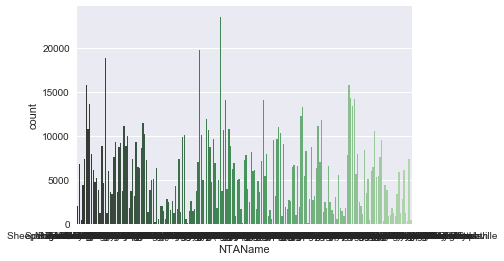

In [48]:
sns.countplot(x='NTAName', data=df, palette ="Greens_d")

In [ ]:
df.sum()